In [1]:
suppressMessages(library(rwwa))

In [2]:
# function to fill infinite probability ratios
infer_infinite <- function(models_in) {
    
    # split out the columns for easier reference
    est <- est_n <- models_in[,1]
    l <- l_n <- models_in[,2]
    u <- u_n <- models_in[,3]
    
    # relabel where infinite best estimate / upper bound occurs
    mnames <- rownames(models_in)
    mnames <- paste0(mnames, c("*","")[is.finite(est)+1])
    mnames <- paste0(mnames, c("*","")[is.finite(u)+1])
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # INFINITE BEST ESTIMATES / UPPER BOUNDS
    # get upper bound where best estimate is infinite
    u_n[!is.finite(u_n)] <- (exp(log(est) + 3 * (log(est) - log(l))))[!is.finite(u_n)]

    # get best estimate, if infinite
    if(any(is.finite(u))) {
        # if any estimated upper bounds are finite, use the maximum upper bound to infer infinite best estimates
        f_upper <- max(u[is.finite(u)])
    } else {
        # otherwise, use the maximum inferred upper bound to infer infinite best estimates
        f_upper <- max(u_n[is.finite(u_n)])
    }
    est_n[!is.finite(est_n)] <- f_upper

    # repeat estimation of upper bound using inferred best estimate
    u_n[!is.finite(u_n)] <- (exp(log(est_n) + 3 * (log(est_n) - log(l))))[!is.finite(u_n)]
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # INFINITE LOWER BOUNDS NOT YET IMPLEMENTED

    return(data.frame("est" = est_n, "lower" = l_n, "upper" = u_n, row.names = mnames))   
}

# Check effect of choice of VPD calculation on fitted trend in HDWI

## GEV

In [212]:
gmst <- read.table("ts-obs/gmst.txt", col.names = c("year", "gmst"))

cov_2025 <- gmst[gmst$year == 2025,"gmst",drop = F]
cov_pi <- cov_2025 - 1.3

rnm = "korea"
for(fnm in list.files("ts-obs", pattern = paste0("hdwi.+ERA5land_",rnm), full.names = T)) {
    res_fnm <- gsub(".dat", "_gev.csv", gsub("ts-obs/korea-fires", "res-obs/res-scaled", fnm))
    
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "hdwi5x"))
        ts$hdwi5x <- scale(ts$hdwi5x) # rescale the varables for direct comparison
        df <- merge(gmst, ts)
        mdl <- fit_ns("gev", "shift", data = df, varnm = "hdwi5x", covnm = c("gmst"), lower = F)
        boot_res <- boot_ci(mdl, cov_f = cov_2025, cov_cf = cov_pi)
        write.csv(boot_res, res_fnm)
    }
}

## lognormal

In [214]:
# gmst <- read.table("ts-obs/gmst.txt", col.names = c("year", "gmst"))

# cov_2025 <- gmst[gmst$year == 2025,"gmst",drop = F]
# cov_pi <- cov_2025 - 1.3

# rnm = "korea"
# for(fnm in list.files("ts", pattern = paste0("hdwi.+ERA5land_",rnm), full.names = T)) {
#     res_fnm <- gsub(".dat", "_lnorm.csv", gsub("ts/korea-fires", "res/res-scaled", fnm))
    
#     if(!file.exists(res_fnm)) {
#         ts <- load_ts(fnm, col.names = c("year", "hdwi5x"))
#         ts$hdwi5x <- scale(ts$hdwi5x) # rescale the varables for direct comparison
#         ts$hdwi5x <- log(ts$hdwi5x)
#         df <- merge(gmst, ts)
#         mdl <- fit_ns("norm", "shift", data = df, varnm = "hdwi5x", covnm = c("gmst"), lower = F)
#         boot_res <- boot_ci(mdl, cov_f = cov_2025, cov_cf = cov_pi)
#         write.csv(boot_res, res_fnm)
#     }
# }

In [ ]:
prep_window(c(1,2))

plot(density(ts$hdwi5x), ylim = c(0,2))
mdl <- strip(fevd(ts$hdwi5x))
lines(x <- seq(0,3,0.01), devd(x, loc = mdl["location"], shape = mdl["shape"], scale = mdl["scale"]), col = "blue")

plot(density(log(ts$hdwi5x)), ylim = c(0,2))
lines(x <- seq(-0.5,1.5,0.01), dnorm(x, mean(log(ts$hdwi5x)), sd(log(ts$hdwi5x))), col = "blue")

In [220]:
# compile results
obs_res <- t(sapply(list.files("res-obs", pattern = "res-scaled.+korea_gev", full.names = T), function(fnm) {
    res <- read.csv(fnm, row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
}))
rownames(obs_res) <- sapply(strsplit(rownames(obs_res), "_"), "[", 2)

write.csv(obs_res, "res-scaled_gev_kr.csv")

# HDWI trend in climate models

In [4]:
# provisional values for initial trend check
rp <- 10
nsamp <- 500


## CMIP6

In [176]:
for (fnm in list.files("ts-cmip6", pattern = "hdwi5x.+kr", full.names = T)) {
        
    res_fnm <- gsub("ts", "res", gsub(".dat", ".csv", fnm))
    if (file.exists(res_fnm)) next
    
    gcm <- paste0(strsplit(fnm, "_")[[1]][4:5], collapse = "_")
    
    # check if GMST time series exists
    gmst_fnm <- list.files("ts-cmip6", pattern = paste0("SGSAT.+", gcm), full.names = T)
    if(length(gmst_fnm) == 0) next
    
    # load all the data
    ts <- load_ts(fnm, col.names = c("year", "hdwi5x"))
    gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
    df <- merge(gmst, ts)
    
    mdl <- fit_ns(dist = "gev", type = "shift", data = df, varnm = "hdwi5x", covnm = c("gmst"), lower = F)
        
    # use model's 2025 GMST to define factual climate        
    cov_now <- df[df$year == 2025,"gmst",drop = F]
    cov_hist <- cov_now - 1.3
    cov_fut <- cov_now + 1.3

    # bootstrap results
    res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut, y_now = 2025, y_start = 1940, y_fut = 2070, nsamp = nsamp, di_relative = F)
    res <- cbind(res, data.frame("ystart" = min(df$year), "yend" = max(df$year)))
    write.csv(res, res_fnm)

    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res-cmip6/", "mdl-eval/rlplot_", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
            plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = gsub("ts/", "", gsub(".csv", "", fnm)))
        }; dev.off()
    }
}

In [179]:
# compile results
res <- t(sapply(list.files("res-cmip6", pattern = "hdwi5x.+kr", full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(rnm) paste0(strsplit(rnm,"_")[[1]][4:5], collapse = "_"))       
write.csv(res, "res-cmip6_hdwi5x_kr.csv")


## HighResMIP

In [158]:
for (fnm in list.files("ts-highresmip", pattern = "hdwi5x_.+kr", full.names = T)) {
    res_fnm <- gsub("ts", "res", gsub(".dat", ".csv", fnm))
    if (file.exists(res_fnm)) next
    
    gcm <- paste0(strsplit(fnm, "_")[[1]][4:5], collapse = "_")
    
    # check if GMST time series exists
    gmst_fnm <- list.files("ts-highresmip", pattern = paste0("GSAT.+", gcm), full.names = T)
    if(length(gmst_fnm) == 0) next
    
    # load all the data
    ts <- load_ts(fnm, col.names = c("year", "hdwi5x"))
    gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
    df <- merge(gmst, ts)
    
    mdl <- fit_ns(dist = "gev", type = "shift", data = df, varnm = "hdwi5x", covnm = c("gmst"), lower = F)
    
    # use model's 2025 GMST to define factual climate        
    cov_now <- df[df$year == 2025,"gmst",drop = F]
    cov_hist <- cov_now - 1.3
    cov_fut <- cov_now + 1.3

    # bootstrap results
    res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut, y_now = 2025, y_start = 1940, y_fut = 2070, nsamp = nsamp, di_relative = F)
    res <- cbind(res, data.frame("ystart" = min(df$year), "yend" = max(df$year)))
    write.csv(res, res_fnm)
    
    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res-highresmip/", "mdl-eval/rlplot_", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
            plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = gsub("ts/", "", gsub(".csv", "", fnm)))
        }; dev.off()
    }
}

In [232]:
res <- t(sapply(list.files("res-highresmip", pattern = "hdwi5x.+kr", full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(rnm) paste0(strsplit(rnm,"_")[[1]][4:5], collapse = "_"))           
write.csv(res, "res-highresmip_hdwi5x_kr.csv")


## AM2.5 / FLOR

In [6]:
# provisional values for initial trend check
rp <- 10
nsamp <- 100

for (fnm in list.files("ts-princeton", pattern = "hdwi5x_.+kr", full.names = T)[1:5]) {
    res_fnm <- gsub("ts", "res", gsub(".dat", ".csv", fnm))
    if (file.exists(res_fnm)) next
    
    gcm <- strsplit(fnm, "_")[[1]][3]
    
    # check that GMST time series exists
    gmst_fnm <- list.files("ts-princeton", pattern = paste0("gmst_", gcm), full.names = T)
    if(length(gmst_fnm) == 0) next
    
    # load all the data
    ts <- load_ts(fnm, col.names = c("year", "hdwi5x"))
    gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
    df <- merge(gmst, ts)
    
    mdl <- fit_ns(dist = "gev", type = "shift", data = df, varnm = "hdwi5x", covnm = c("gmst"), lower = F)
    
    # use model's 2025 GMST to define factual climate        
    cov_now <- df[df$year == 2025,"gmst",drop = F]
    cov_hist <- cov_now - 1.3
    cov_fut <- cov_now + 1.3

    # bootstrap results
    res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut, y_now = 2025, y_start = 1940, y_fut = 2070, nsamp = nsamp, di_relative = F)
    res <- cbind(res, data.frame("ystart" = min(df$year), "yend" = max(df$year)))
    write.csv(res, res_fnm)
    
    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res-princeton/", "mdl-eval/rlplot_", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
            plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = gsub("ts/", "", gsub(".csv", "", fnm)))
        }; dev.off()
    }
}

In [21]:
res <- t(sapply(list.files("res-princeton", pattern = "hdwi5x.+kr", full.names = T), read.csv, row.names = "X"))

# Synthesis of initial results

In [18]:
res_scaled <- read.csv("res-scaled_gev_kr.csv", row.names = "X")

res_cmip6 <- read.csv("res-cmip6_hdwi5x_kr.csv", row.names = "X")
res_highresmip <- read.csv("res-highresmip_hdwi5x_kr.csv", row.names = "X")
res_princeton <- read.csv("res-princeton_hdwi5x_kr.csv", row.names = "X")

res_models <- rbind(res_cmip6, res_highresmip)

In [19]:
synth_dI_attr <- synthesis(obs_in = res_scaled[,grepl("dI.abs", colnames(res_scaled)),drop = F],
                  models_in = res_models[,grepl("attr_dI.abs", colnames(res_models))],
                  synth_type = "abs")

synth_PR_attr <- synthesis(obs_in = infer_infinite(res_scaled[,grepl("PR", colnames(res_scaled)),drop = F]),
                  models_in = infer_infinite(res_models[,grepl("attr_PR", colnames(res_models))]),
                  synth_type = "PR")

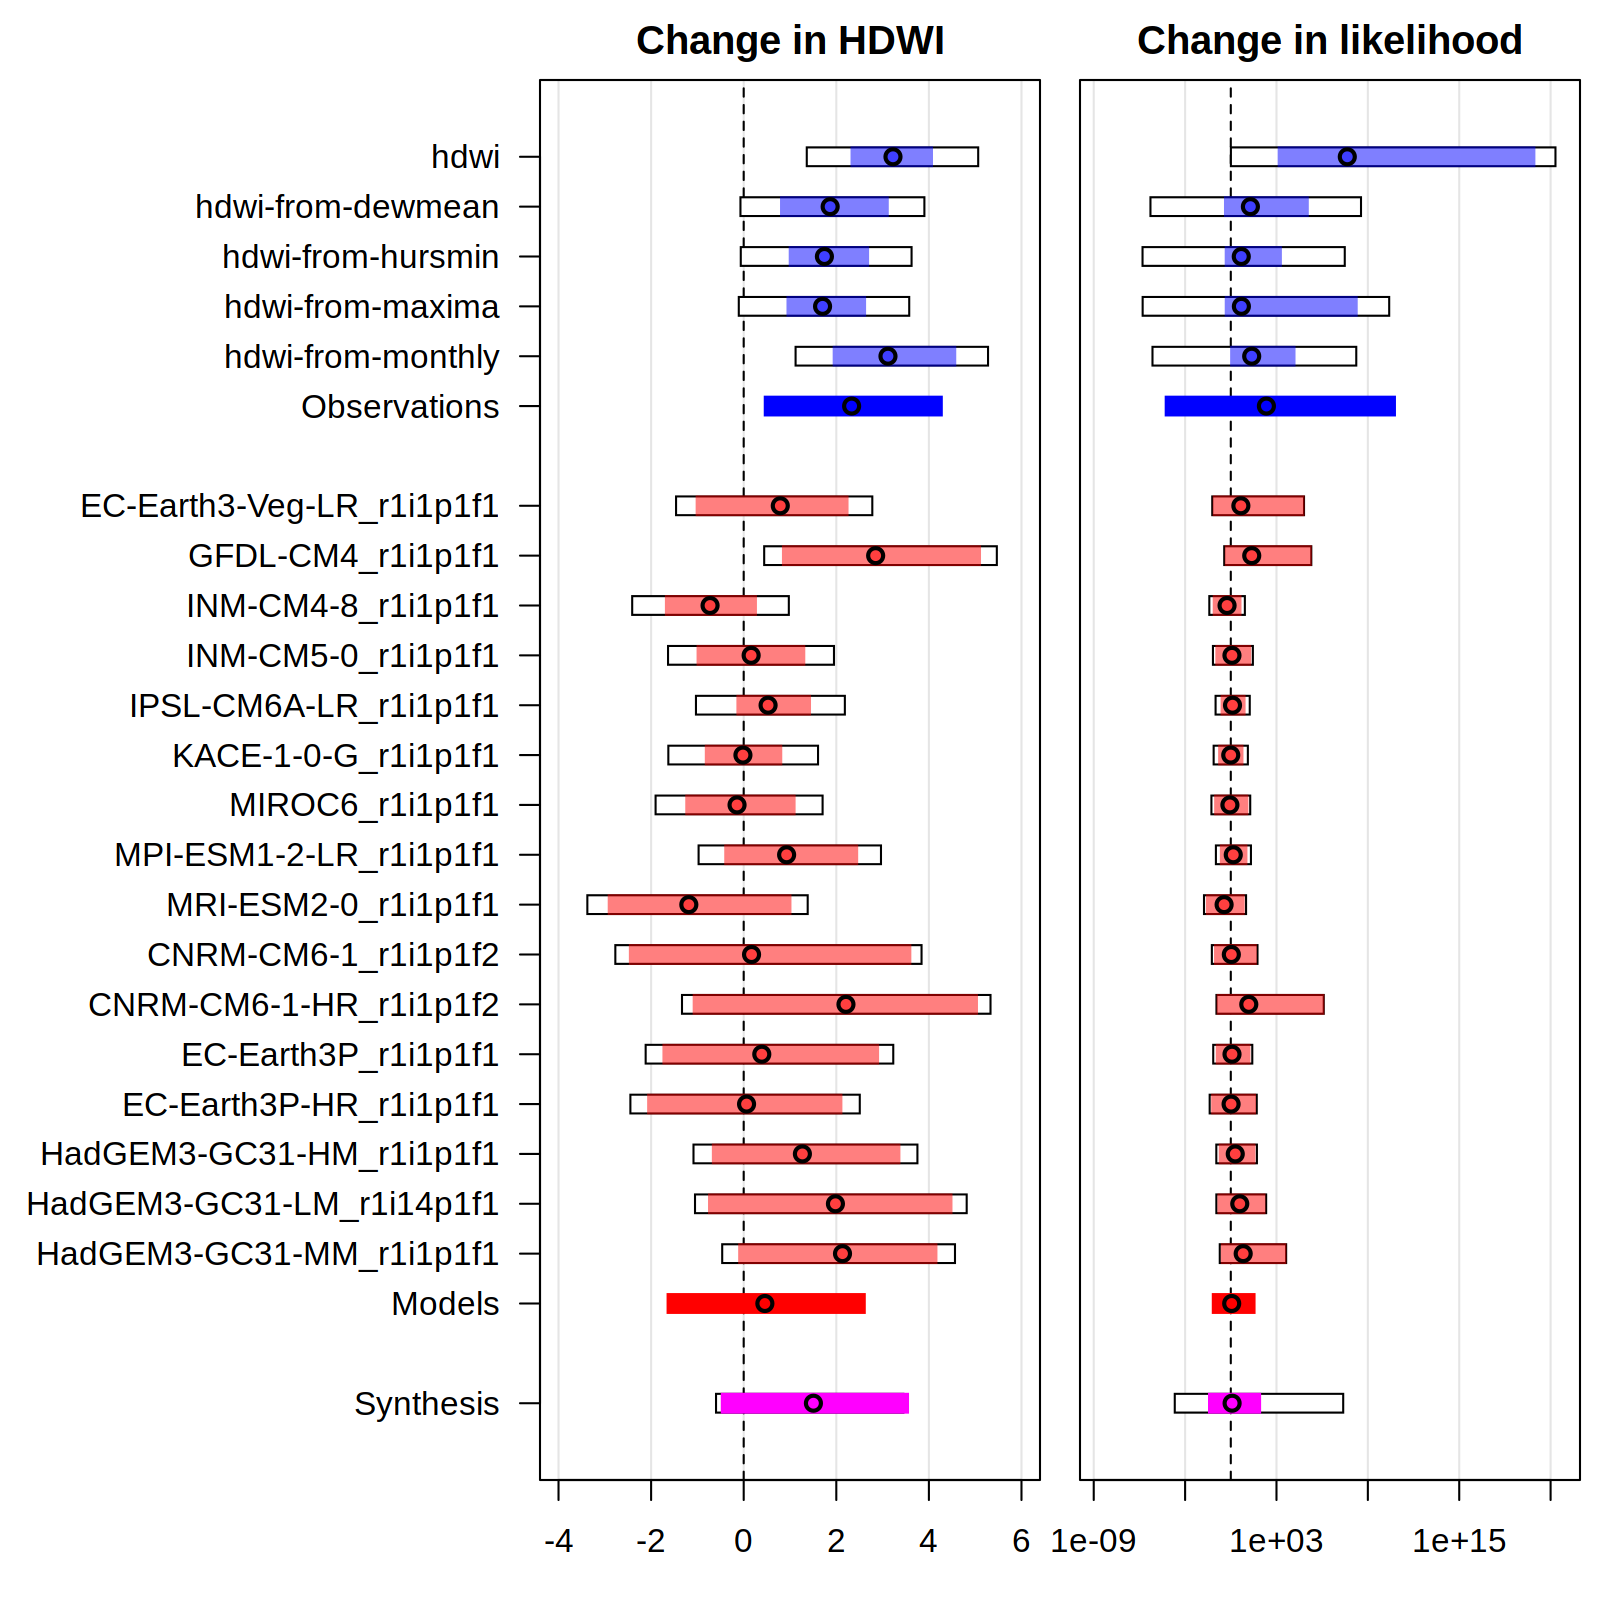

In [20]:
prep_window(c(1,2), h = 8, oma = c(0,13,0,0), mar = c(3,0.5,2,0.5))

plot_synthesis(synth_dI_attr, main = "Change in HDWI")
plot_synthesis(synth_PR_attr, hide_labels = T, main = "Change in likelihood")